# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocs you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

Using TensorFlow backend.


The following code block contains an 8x8 matrix that will be used as a maze object:

In [2]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [3]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [4]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


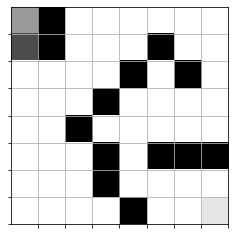

In [5]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [6]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [7]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [8]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [9]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
# pseudocode:
    # For each epoch:
    for epoch in range(n_epoch):
        print('Starting epoch for loop...')
    #    Agent_cell = randomly select a free cell
    #   Matrix is 8X8, so we need to randomly select a number between 0 and 7 
        agent_cell = np.random.randint(0, high=7, size=2)
    #    Reset the maze with agent set to above position       
    #    Review the reset method in the TreasureMaze.py class.
        qmaze.reset([0,0])
        loss = 0.
        game_over = False        
    #    envstate = Environment.current_state
    #    Review the observe method in the TreasureMaze.py class.
        envstate = qmaze.observe()
    #    While state is not game over:
        while qmaze.game_status() == 'not_over':
    #       previous_envstate = envstate
            previous_envstate = envstate
            valid_actions = qmaze.valid_actions()
    #       If random number is less than epsilon:
            if np.random.rand() <= epsilon:
    #           Action = randomly choose action (left, right, up, down)
                next_rand_action = np.random.randint(0, high=3, size=1)
    #       Else:
            else:
    #           Action = model.predict(previous_envstate)
                next_rand_action = model.predict(previous_envstate)
    #           Action = argmax(Action)
                next_rand_action = np.argmax(next_rand_action)
    #           If Action is not in valid_actions:
    #               Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
                if next_rand_action not in valid_actions:
                    next_rand_action = np.random.randint(0, high=3, size=1)
    #       envstate, reward, game_status = qmaze.act(action)
    #       Review the act method in the TreasureMaze.py class.
            envstate, reward, game_status = qmaze.act(next_rand_action)
    #       episode = [previous_envstate, action, reward, envstate, game_status]
            episode = [previous_envstate, next_rand_action, reward, envstate, game_status]
    #       Store episode in Experience replay object
    #       Review the remember method in the GameExperience.py class.
            experience.remember(episode)
    #       Train neural network model and evaluate loss
    #       Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method
            inputs = experience.get_data(data_size)
            loss += model.train_on_batch(inputs[0], inputs[1])
        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win count {}".format(epoch, n_epoch, loss, win_history.count(True)))
        win_history.append(play_game(model, qmaze, agent_cell))
        if len(win_history) > hsize:
            del win_history[0]
        win_rate = sum(win_history)/len(win_history)
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

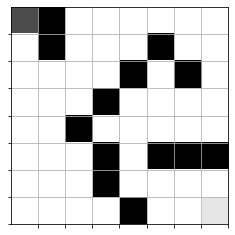

In [10]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [ ]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Starting epoch for loop...
Epoch 000/15000 | Loss 0.8933 | Win count 0
Starting epoch for loop...
Epoch 001/15000 | Loss 0.2000 | Win count 0
Starting epoch for loop...
Epoch 002/15000 | Loss 0.1920 | Win count 0
Starting epoch for loop...
Epoch 003/15000 | Loss 0.1718 | Win count 0
Starting epoch for loop...
Epoch 004/15000 | Loss 0.1490 | Win count 0
Starting epoch for loop...
Epoch 005/15000 | Loss 0.1526 | Win count 0
Starting epoch for loop...
Epoch 006/15000 | Loss 0.1466 | Win count 0
Starting epoch for loop...
Epoch 007/15000 | Loss 0.1583 | Win count 0
Starting epoch for loop...
Epoch 008/15000 | Loss 0.1751 | Win count 0
Starting epoch for loop...
Epoch 009/15000 | Loss 0.1890 | Win count 0
Starting epoch for loop...
Epoch 010/15000 | Loss 0.2316 | Win count 0
Starting epoch for loop...
Epoch 011/15000 | Loss 0.2704 | Win count 0
Starting epoch for loop...
Epoch 012/15000 | Loss 0.2132 | Win count 0
Starting epoch for loop...
Epoch 013/15000 | Loss 0.1944 | Win count 0
Starti

Epoch 116/15000 | Loss 0.0560 | Win count 5
Starting epoch for loop...
Epoch 117/15000 | Loss 0.0539 | Win count 5
Starting epoch for loop...
Epoch 118/15000 | Loss 0.0366 | Win count 5
Starting epoch for loop...
Epoch 119/15000 | Loss 0.0585 | Win count 5
Starting epoch for loop...
Epoch 120/15000 | Loss 0.0477 | Win count 5
Starting epoch for loop...
Epoch 121/15000 | Loss 0.0733 | Win count 5
Starting epoch for loop...
Epoch 122/15000 | Loss 0.0508 | Win count 6
Starting epoch for loop...
Epoch 123/15000 | Loss 0.0919 | Win count 6
Starting epoch for loop...
Epoch 124/15000 | Loss 0.0430 | Win count 6
Starting epoch for loop...
Epoch 125/15000 | Loss 0.0862 | Win count 6
Starting epoch for loop...
Epoch 126/15000 | Loss 0.1014 | Win count 7
Starting epoch for loop...
Epoch 127/15000 | Loss 0.0837 | Win count 6
Starting epoch for loop...
Epoch 128/15000 | Loss 0.0872 | Win count 6
Starting epoch for loop...
Epoch 129/15000 | Loss 0.0587 | Win count 6
Starting epoch for loop...
Epoch 

Epoch 231/15000 | Loss 0.0571 | Win count 7
Starting epoch for loop...
Epoch 232/15000 | Loss 0.0434 | Win count 7
Starting epoch for loop...
Epoch 233/15000 | Loss 0.0455 | Win count 7
Starting epoch for loop...
Epoch 234/15000 | Loss 0.0397 | Win count 7
Starting epoch for loop...
Epoch 235/15000 | Loss 0.0423 | Win count 6
Starting epoch for loop...
Epoch 236/15000 | Loss 0.0669 | Win count 6
Starting epoch for loop...
Epoch 237/15000 | Loss 0.0441 | Win count 7
Starting epoch for loop...
Epoch 238/15000 | Loss 0.0773 | Win count 8
Starting epoch for loop...
Epoch 239/15000 | Loss 0.1090 | Win count 8
Starting epoch for loop...
Epoch 240/15000 | Loss 0.0368 | Win count 8
Starting epoch for loop...
Epoch 241/15000 | Loss 0.0494 | Win count 8
Starting epoch for loop...
Epoch 242/15000 | Loss 0.0877 | Win count 8
Starting epoch for loop...
Epoch 243/15000 | Loss 0.1024 | Win count 8
Starting epoch for loop...
Epoch 244/15000 | Loss 0.0730 | Win count 8
Starting epoch for loop...
Epoch 

Epoch 346/15000 | Loss 0.0277 | Win count 9
Starting epoch for loop...
Epoch 347/15000 | Loss 0.0256 | Win count 9
Starting epoch for loop...
Epoch 348/15000 | Loss 0.1020 | Win count 10
Starting epoch for loop...
Epoch 349/15000 | Loss 0.0232 | Win count 9
Starting epoch for loop...
Epoch 350/15000 | Loss 0.0301 | Win count 9
Starting epoch for loop...
Epoch 351/15000 | Loss 0.0233 | Win count 9
Starting epoch for loop...
Epoch 352/15000 | Loss 0.0260 | Win count 9
Starting epoch for loop...
Epoch 353/15000 | Loss 0.0210 | Win count 9
Starting epoch for loop...
Epoch 354/15000 | Loss 0.0539 | Win count 9
Starting epoch for loop...
Epoch 355/15000 | Loss 0.1311 | Win count 8
Starting epoch for loop...
Epoch 356/15000 | Loss 0.0437 | Win count 8
Starting epoch for loop...
Epoch 357/15000 | Loss 0.0305 | Win count 8
Starting epoch for loop...
Epoch 358/15000 | Loss 0.0350 | Win count 8
Starting epoch for loop...
Epoch 359/15000 | Loss 0.0293 | Win count 7
Starting epoch for loop...
Epoch

Epoch 462/15000 | Loss 0.0199 | Win count 9
Starting epoch for loop...
Epoch 463/15000 | Loss 0.0173 | Win count 9
Starting epoch for loop...
Epoch 464/15000 | Loss 0.0259 | Win count 8
Starting epoch for loop...
Epoch 465/15000 | Loss 0.0527 | Win count 8
Starting epoch for loop...
Epoch 466/15000 | Loss 0.0373 | Win count 7
Starting epoch for loop...
Epoch 467/15000 | Loss 0.0213 | Win count 7
Starting epoch for loop...
Epoch 468/15000 | Loss 0.0318 | Win count 6
Starting epoch for loop...
Epoch 469/15000 | Loss 0.0400 | Win count 6
Starting epoch for loop...
Epoch 470/15000 | Loss 0.0245 | Win count 6
Starting epoch for loop...
Epoch 471/15000 | Loss 0.0281 | Win count 6
Starting epoch for loop...
Epoch 472/15000 | Loss 0.0256 | Win count 5
Starting epoch for loop...
Epoch 473/15000 | Loss 0.0336 | Win count 6
Starting epoch for loop...
Epoch 474/15000 | Loss 0.0414 | Win count 6
Starting epoch for loop...
Epoch 475/15000 | Loss 0.0385 | Win count 6
Starting epoch for loop...
Epoch 

Epoch 578/15000 | Loss 0.0885 | Win count 9
Starting epoch for loop...
Epoch 579/15000 | Loss 0.0316 | Win count 8
Starting epoch for loop...
Epoch 580/15000 | Loss 0.0471 | Win count 9
Starting epoch for loop...
Epoch 581/15000 | Loss 0.0358 | Win count 8
Starting epoch for loop...
Epoch 582/15000 | Loss 0.0572 | Win count 9
Starting epoch for loop...
Epoch 583/15000 | Loss 0.0268 | Win count 9
Starting epoch for loop...
Epoch 584/15000 | Loss 0.0269 | Win count 9
Starting epoch for loop...
Epoch 585/15000 | Loss 0.0218 | Win count 9
Starting epoch for loop...
Epoch 586/15000 | Loss 0.0307 | Win count 10
Starting epoch for loop...
Epoch 587/15000 | Loss 0.0266 | Win count 11
Starting epoch for loop...
Epoch 588/15000 | Loss 0.0276 | Win count 11
Starting epoch for loop...
Epoch 589/15000 | Loss 0.0439 | Win count 12
Starting epoch for loop...
Epoch 590/15000 | Loss 0.0350 | Win count 12
Starting epoch for loop...
Epoch 591/15000 | Loss 0.0774 | Win count 12
Starting epoch for loop...


Epoch 693/15000 | Loss 0.0221 | Win count 13
Starting epoch for loop...
Epoch 694/15000 | Loss 0.0295 | Win count 14
Starting epoch for loop...
Epoch 695/15000 | Loss 0.0216 | Win count 14
Starting epoch for loop...
Epoch 696/15000 | Loss 0.0168 | Win count 14
Starting epoch for loop...
Epoch 697/15000 | Loss 0.0147 | Win count 14
Starting epoch for loop...
Epoch 698/15000 | Loss 0.0207 | Win count 14
Starting epoch for loop...
Epoch 699/15000 | Loss 0.0192 | Win count 14
Starting epoch for loop...
Epoch 700/15000 | Loss 0.0130 | Win count 14
Starting epoch for loop...
Epoch 701/15000 | Loss 0.0331 | Win count 14
Starting epoch for loop...
Epoch 702/15000 | Loss 0.0112 | Win count 13
Starting epoch for loop...
Epoch 703/15000 | Loss 0.0149 | Win count 13
Starting epoch for loop...
Epoch 704/15000 | Loss 0.0162 | Win count 13
Starting epoch for loop...
Epoch 705/15000 | Loss 0.0127 | Win count 12
Starting epoch for loop...
Epoch 706/15000 | Loss 0.0131 | Win count 12
Starting epoch for 

Epoch 807/15000 | Loss 0.0317 | Win count 11
Starting epoch for loop...
Epoch 808/15000 | Loss 0.0669 | Win count 11
Starting epoch for loop...
Epoch 809/15000 | Loss 0.0288 | Win count 11
Starting epoch for loop...
Epoch 810/15000 | Loss 0.0409 | Win count 11
Starting epoch for loop...
Epoch 811/15000 | Loss 0.0345 | Win count 11
Starting epoch for loop...
Epoch 812/15000 | Loss 0.0389 | Win count 10
Starting epoch for loop...
Epoch 813/15000 | Loss 0.0290 | Win count 11
Starting epoch for loop...
Epoch 814/15000 | Loss 0.0275 | Win count 11
Starting epoch for loop...
Epoch 815/15000 | Loss 0.0231 | Win count 11
Starting epoch for loop...
Epoch 816/15000 | Loss 0.0518 | Win count 11
Starting epoch for loop...
Epoch 817/15000 | Loss 0.0371 | Win count 12
Starting epoch for loop...
Epoch 818/15000 | Loss 0.0255 | Win count 12
Starting epoch for loop...
Epoch 819/15000 | Loss 0.0275 | Win count 13
Starting epoch for loop...
Epoch 820/15000 | Loss 0.0202 | Win count 13
Starting epoch for 

Epoch 921/15000 | Loss 0.0147 | Win count 16
Starting epoch for loop...
Epoch 922/15000 | Loss 0.0119 | Win count 16
Starting epoch for loop...
Epoch 923/15000 | Loss 0.0107 | Win count 16
Starting epoch for loop...
Epoch 924/15000 | Loss 0.0133 | Win count 17
Starting epoch for loop...
Epoch 925/15000 | Loss 0.0089 | Win count 17
Starting epoch for loop...
Epoch 926/15000 | Loss 0.0121 | Win count 17
Starting epoch for loop...
Epoch 927/15000 | Loss 0.0101 | Win count 17
Starting epoch for loop...
Epoch 928/15000 | Loss 0.0088 | Win count 18
Starting epoch for loop...
Epoch 929/15000 | Loss 0.0103 | Win count 18
Starting epoch for loop...
Epoch 930/15000 | Loss 0.0108 | Win count 18
Starting epoch for loop...
Epoch 931/15000 | Loss 0.0066 | Win count 19
Starting epoch for loop...
Epoch 932/15000 | Loss 0.0107 | Win count 20
Starting epoch for loop...
Epoch 933/15000 | Loss 0.0081 | Win count 21
Starting epoch for loop...
Epoch 934/15000 | Loss 0.0098 | Win count 21
Starting epoch for 

Epoch 1035/15000 | Loss 0.0387 | Win count 16
Starting epoch for loop...
Epoch 1036/15000 | Loss 0.0779 | Win count 15
Starting epoch for loop...
Epoch 1037/15000 | Loss 0.0468 | Win count 16
Starting epoch for loop...
Epoch 1038/15000 | Loss 0.0465 | Win count 16
Starting epoch for loop...
Epoch 1039/15000 | Loss 0.0344 | Win count 15
Starting epoch for loop...
Epoch 1040/15000 | Loss 0.0341 | Win count 14
Starting epoch for loop...
Epoch 1041/15000 | Loss 0.0409 | Win count 14
Starting epoch for loop...
Epoch 1042/15000 | Loss 0.0396 | Win count 14
Starting epoch for loop...
Epoch 1043/15000 | Loss 0.0550 | Win count 14
Starting epoch for loop...
Epoch 1044/15000 | Loss 0.0320 | Win count 13
Starting epoch for loop...
Epoch 1045/15000 | Loss 0.0436 | Win count 12
Starting epoch for loop...
Epoch 1046/15000 | Loss 0.0334 | Win count 13
Starting epoch for loop...
Epoch 1047/15000 | Loss 0.0232 | Win count 14
Starting epoch for loop...
Epoch 1048/15000 | Loss 0.0242 | Win count 14
Start

Epoch 1148/15000 | Loss 0.0395 | Win count 7
Starting epoch for loop...
Epoch 1149/15000 | Loss 0.0349 | Win count 8
Starting epoch for loop...
Epoch 1150/15000 | Loss 0.0435 | Win count 8
Starting epoch for loop...
Epoch 1151/15000 | Loss 0.0342 | Win count 8
Starting epoch for loop...
Epoch 1152/15000 | Loss 0.0207 | Win count 7
Starting epoch for loop...
Epoch 1153/15000 | Loss 0.0301 | Win count 8
Starting epoch for loop...
Epoch 1154/15000 | Loss 0.0420 | Win count 8
Starting epoch for loop...
Epoch 1155/15000 | Loss 0.0650 | Win count 9
Starting epoch for loop...
Epoch 1156/15000 | Loss 0.0373 | Win count 9
Starting epoch for loop...
Epoch 1157/15000 | Loss 0.0326 | Win count 9
Starting epoch for loop...
Epoch 1158/15000 | Loss 0.0257 | Win count 10
Starting epoch for loop...
Epoch 1159/15000 | Loss 0.0311 | Win count 10
Starting epoch for loop...
Epoch 1160/15000 | Loss 0.0201 | Win count 10
Starting epoch for loop...
Epoch 1161/15000 | Loss 0.0405 | Win count 9
Starting epoch f

Epoch 1261/15000 | Loss 0.0294 | Win count 11
Starting epoch for loop...
Epoch 1262/15000 | Loss 0.0482 | Win count 10
Starting epoch for loop...
Epoch 1263/15000 | Loss 0.0212 | Win count 10
Starting epoch for loop...
Epoch 1264/15000 | Loss 0.0261 | Win count 10
Starting epoch for loop...
Epoch 1265/15000 | Loss 0.0207 | Win count 10
Starting epoch for loop...
Epoch 1266/15000 | Loss 0.0233 | Win count 10
Starting epoch for loop...
Epoch 1267/15000 | Loss 0.0493 | Win count 10
Starting epoch for loop...
Epoch 1268/15000 | Loss 0.0197 | Win count 9
Starting epoch for loop...
Epoch 1269/15000 | Loss 0.0291 | Win count 10
Starting epoch for loop...
Epoch 1270/15000 | Loss 0.0373 | Win count 9
Starting epoch for loop...
Epoch 1271/15000 | Loss 0.0152 | Win count 9
Starting epoch for loop...
Epoch 1272/15000 | Loss 0.0137 | Win count 9
Starting epoch for loop...
Epoch 1273/15000 | Loss 0.0168 | Win count 10
Starting epoch for loop...
Epoch 1274/15000 | Loss 0.0227 | Win count 10
Starting 

Epoch 1374/15000 | Loss 0.0248 | Win count 9
Starting epoch for loop...
Epoch 1375/15000 | Loss 0.0313 | Win count 8
Starting epoch for loop...
Epoch 1376/15000 | Loss 0.0293 | Win count 7
Starting epoch for loop...
Epoch 1377/15000 | Loss 0.0221 | Win count 7
Starting epoch for loop...
Epoch 1378/15000 | Loss 0.0349 | Win count 7
Starting epoch for loop...
Epoch 1379/15000 | Loss 0.0140 | Win count 7
Starting epoch for loop...
Epoch 1380/15000 | Loss 0.0223 | Win count 7
Starting epoch for loop...
Epoch 1381/15000 | Loss 0.0172 | Win count 7
Starting epoch for loop...
Epoch 1382/15000 | Loss 0.0222 | Win count 6
Starting epoch for loop...
Epoch 1383/15000 | Loss 0.0165 | Win count 6
Starting epoch for loop...
Epoch 1384/15000 | Loss 0.0180 | Win count 6
Starting epoch for loop...
Epoch 1385/15000 | Loss 0.0195 | Win count 6
Starting epoch for loop...
Epoch 1386/15000 | Loss 0.0214 | Win count 6
Starting epoch for loop...
Epoch 1387/15000 | Loss 0.0254 | Win count 5
Starting epoch for 

Epoch 1488/15000 | Loss 0.0663 | Win count 11
Starting epoch for loop...
Epoch 1489/15000 | Loss 0.0284 | Win count 11
Starting epoch for loop...
Epoch 1490/15000 | Loss 0.0290 | Win count 11
Starting epoch for loop...
Epoch 1491/15000 | Loss 0.0374 | Win count 11
Starting epoch for loop...
Epoch 1492/15000 | Loss 0.0271 | Win count 11
Starting epoch for loop...
Epoch 1493/15000 | Loss 0.0342 | Win count 10
Starting epoch for loop...
Epoch 1494/15000 | Loss 0.0285 | Win count 10
Starting epoch for loop...
Epoch 1495/15000 | Loss 0.0240 | Win count 10
Starting epoch for loop...
Epoch 1496/15000 | Loss 0.0256 | Win count 10
Starting epoch for loop...
Epoch 1497/15000 | Loss 0.0212 | Win count 11
Starting epoch for loop...
Epoch 1498/15000 | Loss 0.0577 | Win count 12
Starting epoch for loop...
Epoch 1499/15000 | Loss 0.0194 | Win count 11
Starting epoch for loop...
Epoch 1500/15000 | Loss 0.0283 | Win count 10
Starting epoch for loop...
Epoch 1501/15000 | Loss 0.0219 | Win count 10
Start

Epoch 1601/15000 | Loss 0.0258 | Win count 14
Starting epoch for loop...
Epoch 1602/15000 | Loss 0.0173 | Win count 14
Starting epoch for loop...
Epoch 1603/15000 | Loss 0.0207 | Win count 13
Starting epoch for loop...
Epoch 1604/15000 | Loss 0.0295 | Win count 13
Starting epoch for loop...
Epoch 1605/15000 | Loss 0.0172 | Win count 14
Starting epoch for loop...
Epoch 1606/15000 | Loss 0.0220 | Win count 13
Starting epoch for loop...
Epoch 1607/15000 | Loss 0.0198 | Win count 14
Starting epoch for loop...
Epoch 1608/15000 | Loss 0.0184 | Win count 15
Starting epoch for loop...
Epoch 1609/15000 | Loss 0.0244 | Win count 16
Starting epoch for loop...
Epoch 1610/15000 | Loss 0.0220 | Win count 17
Starting epoch for loop...
Epoch 1611/15000 | Loss 0.0182 | Win count 16
Starting epoch for loop...
Epoch 1612/15000 | Loss 0.0169 | Win count 16
Starting epoch for loop...
Epoch 1613/15000 | Loss 0.0265 | Win count 15
Starting epoch for loop...
Epoch 1614/15000 | Loss 0.0164 | Win count 15
Start

Epoch 1714/15000 | Loss 0.0093 | Win count 20
Starting epoch for loop...
Epoch 1715/15000 | Loss 0.0119 | Win count 20
Starting epoch for loop...
Epoch 1716/15000 | Loss 0.0085 | Win count 19
Starting epoch for loop...
Epoch 1717/15000 | Loss 0.0126 | Win count 19
Starting epoch for loop...
Epoch 1718/15000 | Loss 0.0149 | Win count 20
Starting epoch for loop...
Epoch 1719/15000 | Loss 0.0115 | Win count 20
Starting epoch for loop...
Epoch 1720/15000 | Loss 0.0064 | Win count 19
Starting epoch for loop...
Epoch 1721/15000 | Loss 0.0225 | Win count 18
Starting epoch for loop...
Epoch 1722/15000 | Loss 0.0096 | Win count 19
Starting epoch for loop...
Epoch 1723/15000 | Loss 0.0089 | Win count 19
Starting epoch for loop...
Epoch 1724/15000 | Loss 0.0070 | Win count 20
Starting epoch for loop...
Epoch 1725/15000 | Loss 0.0129 | Win count 19
Starting epoch for loop...
Epoch 1726/15000 | Loss 0.0116 | Win count 18
Starting epoch for loop...
Epoch 1727/15000 | Loss 0.0124 | Win count 17
Start

Epoch 1827/15000 | Loss 0.0114 | Win count 14
Starting epoch for loop...
Epoch 1828/15000 | Loss 0.0130 | Win count 14
Starting epoch for loop...
Epoch 1829/15000 | Loss 0.0138 | Win count 15
Starting epoch for loop...
Epoch 1830/15000 | Loss 0.0195 | Win count 16
Starting epoch for loop...
Epoch 1831/15000 | Loss 0.0168 | Win count 16
Starting epoch for loop...
Epoch 1832/15000 | Loss 0.0170 | Win count 17
Starting epoch for loop...
Epoch 1833/15000 | Loss 0.0184 | Win count 17
Starting epoch for loop...
Epoch 1834/15000 | Loss 0.0124 | Win count 16
Starting epoch for loop...
Epoch 1835/15000 | Loss 0.0143 | Win count 16
Starting epoch for loop...
Epoch 1836/15000 | Loss 0.0172 | Win count 17
Starting epoch for loop...
Epoch 1837/15000 | Loss 0.0143 | Win count 16
Starting epoch for loop...
Epoch 1838/15000 | Loss 0.0099 | Win count 16
Starting epoch for loop...
Epoch 1839/15000 | Loss 0.0139 | Win count 16
Starting epoch for loop...
Epoch 1840/15000 | Loss 0.0097 | Win count 17
Start

Epoch 1940/15000 | Loss 0.0172 | Win count 20
Starting epoch for loop...
Epoch 1941/15000 | Loss 0.0297 | Win count 21
Starting epoch for loop...
Epoch 1942/15000 | Loss 0.0139 | Win count 20
Starting epoch for loop...
Epoch 1943/15000 | Loss 0.0193 | Win count 19
Starting epoch for loop...
Epoch 1944/15000 | Loss 0.0232 | Win count 18
Starting epoch for loop...
Epoch 1945/15000 | Loss 0.0218 | Win count 18
Starting epoch for loop...
Epoch 1946/15000 | Loss 0.0260 | Win count 19
Starting epoch for loop...
Epoch 1947/15000 | Loss 0.0305 | Win count 18
Starting epoch for loop...
Epoch 1948/15000 | Loss 0.0281 | Win count 18
Starting epoch for loop...
Epoch 1949/15000 | Loss 0.0234 | Win count 19
Starting epoch for loop...
Epoch 1950/15000 | Loss 0.0402 | Win count 19
Starting epoch for loop...
Epoch 1951/15000 | Loss 0.0255 | Win count 18
Starting epoch for loop...
Epoch 1952/15000 | Loss 0.0255 | Win count 18
Starting epoch for loop...
Epoch 1953/15000 | Loss 0.0442 | Win count 17
Start

Epoch 2053/15000 | Loss 0.0212 | Win count 21
Starting epoch for loop...
Epoch 2054/15000 | Loss 0.0145 | Win count 22
Starting epoch for loop...
Epoch 2055/15000 | Loss 0.0152 | Win count 23
Starting epoch for loop...
Epoch 2056/15000 | Loss 0.0105 | Win count 23
Starting epoch for loop...
Epoch 2057/15000 | Loss 0.0117 | Win count 23
Starting epoch for loop...
Epoch 2058/15000 | Loss 0.0147 | Win count 24
Starting epoch for loop...
Epoch 2059/15000 | Loss 0.0129 | Win count 23
Starting epoch for loop...
Epoch 2060/15000 | Loss 0.0157 | Win count 22
Starting epoch for loop...
Epoch 2061/15000 | Loss 0.0186 | Win count 21
Starting epoch for loop...
Epoch 2062/15000 | Loss 0.0111 | Win count 21
Starting epoch for loop...
Epoch 2063/15000 | Loss 0.0093 | Win count 20
Starting epoch for loop...
Epoch 2064/15000 | Loss 0.0132 | Win count 20
Starting epoch for loop...
Epoch 2065/15000 | Loss 0.0085 | Win count 19
Starting epoch for loop...
Epoch 2066/15000 | Loss 0.0108 | Win count 19
Start

Epoch 2166/15000 | Loss 0.0206 | Win count 19
Starting epoch for loop...
Epoch 2167/15000 | Loss 0.0277 | Win count 19
Starting epoch for loop...
Epoch 2168/15000 | Loss 0.0166 | Win count 18
Starting epoch for loop...
Epoch 2169/15000 | Loss 0.0239 | Win count 18
Starting epoch for loop...
Epoch 2170/15000 | Loss 0.0155 | Win count 18
Starting epoch for loop...
Epoch 2171/15000 | Loss 0.0126 | Win count 18
Starting epoch for loop...
Epoch 2172/15000 | Loss 0.0115 | Win count 18
Starting epoch for loop...
Epoch 2173/15000 | Loss 0.0075 | Win count 18
Starting epoch for loop...
Epoch 2174/15000 | Loss 0.0102 | Win count 18
Starting epoch for loop...
Epoch 2175/15000 | Loss 0.0084 | Win count 18
Starting epoch for loop...
Epoch 2176/15000 | Loss 0.0103 | Win count 17
Starting epoch for loop...
Epoch 2177/15000 | Loss 0.0147 | Win count 16
Starting epoch for loop...
Epoch 2178/15000 | Loss 0.0115 | Win count 16
Starting epoch for loop...
Epoch 2179/15000 | Loss 0.0096 | Win count 16
Start

Epoch 2279/15000 | Loss 0.0228 | Win count 20
Starting epoch for loop...
Epoch 2280/15000 | Loss 0.0205 | Win count 19
Starting epoch for loop...
Epoch 2281/15000 | Loss 0.0168 | Win count 19
Starting epoch for loop...
Epoch 2282/15000 | Loss 0.0157 | Win count 19
Starting epoch for loop...
Epoch 2283/15000 | Loss 0.0390 | Win count 19
Starting epoch for loop...
Epoch 2284/15000 | Loss 0.0361 | Win count 19
Starting epoch for loop...
Epoch 2285/15000 | Loss 0.0165 | Win count 19
Starting epoch for loop...
Epoch 2286/15000 | Loss 0.0155 | Win count 19
Starting epoch for loop...
Epoch 2287/15000 | Loss 0.0148 | Win count 20
Starting epoch for loop...
Epoch 2288/15000 | Loss 0.0149 | Win count 21
Starting epoch for loop...
Epoch 2289/15000 | Loss 0.0121 | Win count 21
Starting epoch for loop...
Epoch 2290/15000 | Loss 0.0159 | Win count 21
Starting epoch for loop...
Epoch 2291/15000 | Loss 0.0142 | Win count 21
Starting epoch for loop...
Epoch 2292/15000 | Loss 0.0104 | Win count 21
Start

Epoch 2392/15000 | Loss 0.0171 | Win count 21
Starting epoch for loop...
Epoch 2393/15000 | Loss 0.0332 | Win count 22
Starting epoch for loop...
Epoch 2394/15000 | Loss 0.1500 | Win count 21
Starting epoch for loop...
Epoch 2395/15000 | Loss 0.0246 | Win count 21
Starting epoch for loop...
Epoch 2396/15000 | Loss 0.0245 | Win count 22
Starting epoch for loop...
Epoch 2397/15000 | Loss 0.0199 | Win count 22
Starting epoch for loop...
Epoch 2398/15000 | Loss 0.0214 | Win count 22
Starting epoch for loop...
Epoch 2399/15000 | Loss 0.0239 | Win count 22
Starting epoch for loop...
Epoch 2400/15000 | Loss 0.0253 | Win count 21
Starting epoch for loop...
Epoch 2401/15000 | Loss 0.0187 | Win count 20
Starting epoch for loop...
Epoch 2402/15000 | Loss 0.0299 | Win count 20
Starting epoch for loop...
Epoch 2403/15000 | Loss 0.0178 | Win count 20
Starting epoch for loop...
Epoch 2404/15000 | Loss 0.0212 | Win count 19
Starting epoch for loop...
Epoch 2405/15000 | Loss 0.0204 | Win count 18
Start

Epoch 2505/15000 | Loss 0.0235 | Win count 13
Starting epoch for loop...
Epoch 2506/15000 | Loss 0.0195 | Win count 14
Starting epoch for loop...
Epoch 2507/15000 | Loss 0.0224 | Win count 14
Starting epoch for loop...
Epoch 2508/15000 | Loss 0.0160 | Win count 14
Starting epoch for loop...
Epoch 2509/15000 | Loss 0.0144 | Win count 15
Starting epoch for loop...
Epoch 2510/15000 | Loss 0.0160 | Win count 15
Starting epoch for loop...
Epoch 2511/15000 | Loss 0.0171 | Win count 14
Starting epoch for loop...
Epoch 2512/15000 | Loss 0.0159 | Win count 13
Starting epoch for loop...
Epoch 2513/15000 | Loss 0.0160 | Win count 13
Starting epoch for loop...
Epoch 2514/15000 | Loss 0.0158 | Win count 14
Starting epoch for loop...
Epoch 2515/15000 | Loss 0.0125 | Win count 14
Starting epoch for loop...
Epoch 2516/15000 | Loss 0.0130 | Win count 15
Starting epoch for loop...
Epoch 2517/15000 | Loss 0.0131 | Win count 16
Starting epoch for loop...
Epoch 2518/15000 | Loss 0.0162 | Win count 17
Start

Epoch 2618/15000 | Loss 0.0347 | Win count 19
Starting epoch for loop...
Epoch 2619/15000 | Loss 0.0223 | Win count 20
Starting epoch for loop...
Epoch 2620/15000 | Loss 0.0206 | Win count 20
Starting epoch for loop...
Epoch 2621/15000 | Loss 0.0265 | Win count 19
Starting epoch for loop...
Epoch 2622/15000 | Loss 0.0302 | Win count 19
Starting epoch for loop...
Epoch 2623/15000 | Loss 0.0339 | Win count 18
Starting epoch for loop...
Epoch 2624/15000 | Loss 0.0232 | Win count 17
Starting epoch for loop...
Epoch 2625/15000 | Loss 0.0360 | Win count 16
Starting epoch for loop...
Epoch 2626/15000 | Loss 0.0287 | Win count 15
Starting epoch for loop...
Epoch 2627/15000 | Loss 0.0850 | Win count 14
Starting epoch for loop...
Epoch 2628/15000 | Loss 0.0500 | Win count 13
Starting epoch for loop...
Epoch 2629/15000 | Loss 0.0288 | Win count 14
Starting epoch for loop...
Epoch 2630/15000 | Loss 0.0466 | Win count 14
Starting epoch for loop...
Epoch 2631/15000 | Loss 0.0738 | Win count 13
Start

Epoch 2731/15000 | Loss 0.0216 | Win count 10
Starting epoch for loop...
Epoch 2732/15000 | Loss 0.0238 | Win count 11
Starting epoch for loop...
Epoch 2733/15000 | Loss 0.0215 | Win count 10
Starting epoch for loop...
Epoch 2734/15000 | Loss 0.0228 | Win count 11
Starting epoch for loop...
Epoch 2735/15000 | Loss 0.0226 | Win count 12
Starting epoch for loop...
Epoch 2736/15000 | Loss 0.0267 | Win count 13
Starting epoch for loop...
Epoch 2737/15000 | Loss 0.0173 | Win count 12
Starting epoch for loop...
Epoch 2738/15000 | Loss 0.0180 | Win count 12
Starting epoch for loop...
Epoch 2739/15000 | Loss 0.0130 | Win count 12
Starting epoch for loop...
Epoch 2740/15000 | Loss 0.0148 | Win count 13
Starting epoch for loop...
Epoch 2741/15000 | Loss 0.0114 | Win count 13
Starting epoch for loop...
Epoch 2742/15000 | Loss 0.0149 | Win count 14
Starting epoch for loop...
Epoch 2743/15000 | Loss 0.0124 | Win count 15
Starting epoch for loop...
Epoch 2744/15000 | Loss 0.0108 | Win count 16
Start

Epoch 2844/15000 | Loss 0.0228 | Win count 13
Starting epoch for loop...
Epoch 2845/15000 | Loss 0.0180 | Win count 12
Starting epoch for loop...
Epoch 2846/15000 | Loss 0.0158 | Win count 13
Starting epoch for loop...
Epoch 2847/15000 | Loss 0.0448 | Win count 14
Starting epoch for loop...
Epoch 2848/15000 | Loss 0.0561 | Win count 14
Starting epoch for loop...
Epoch 2849/15000 | Loss 0.0263 | Win count 13
Starting epoch for loop...
Epoch 2850/15000 | Loss 0.0263 | Win count 13
Starting epoch for loop...
Epoch 2851/15000 | Loss 0.0449 | Win count 13
Starting epoch for loop...
Epoch 2852/15000 | Loss 0.0237 | Win count 14
Starting epoch for loop...
Epoch 2853/15000 | Loss 0.0265 | Win count 15
Starting epoch for loop...
Epoch 2854/15000 | Loss 0.0209 | Win count 15
Starting epoch for loop...
Epoch 2855/15000 | Loss 0.0228 | Win count 15
Starting epoch for loop...
Epoch 2856/15000 | Loss 0.0302 | Win count 15
Starting epoch for loop...
Epoch 2857/15000 | Loss 0.0223 | Win count 14
Start

Epoch 2957/15000 | Loss 0.0194 | Win count 16
Starting epoch for loop...
Epoch 2958/15000 | Loss 0.0296 | Win count 17
Starting epoch for loop...
Epoch 2959/15000 | Loss 0.0142 | Win count 18
Starting epoch for loop...
Epoch 2960/15000 | Loss 0.0187 | Win count 19
Starting epoch for loop...
Epoch 2961/15000 | Loss 0.0142 | Win count 18
Starting epoch for loop...
Epoch 2962/15000 | Loss 0.0141 | Win count 19
Starting epoch for loop...
Epoch 2963/15000 | Loss 0.0146 | Win count 19
Starting epoch for loop...
Epoch 2964/15000 | Loss 0.0157 | Win count 18
Starting epoch for loop...
Epoch 2965/15000 | Loss 0.0281 | Win count 17
Starting epoch for loop...
Epoch 2966/15000 | Loss 0.0163 | Win count 18
Starting epoch for loop...
Epoch 2967/15000 | Loss 0.0220 | Win count 18
Starting epoch for loop...
Epoch 2968/15000 | Loss 0.0185 | Win count 19
Starting epoch for loop...
Epoch 2969/15000 | Loss 0.0199 | Win count 18
Starting epoch for loop...
Epoch 2970/15000 | Loss 0.0172 | Win count 19
Start

Epoch 3070/15000 | Loss 0.0186 | Win count 13
Starting epoch for loop...
Epoch 3071/15000 | Loss 0.0166 | Win count 13
Starting epoch for loop...
Epoch 3072/15000 | Loss 0.0203 | Win count 13
Starting epoch for loop...
Epoch 3073/15000 | Loss 0.0151 | Win count 13
Starting epoch for loop...
Epoch 3074/15000 | Loss 0.0179 | Win count 13
Starting epoch for loop...
Epoch 3075/15000 | Loss 0.0183 | Win count 12
Starting epoch for loop...
Epoch 3076/15000 | Loss 0.0198 | Win count 11
Starting epoch for loop...
Epoch 3077/15000 | Loss 0.0227 | Win count 11
Starting epoch for loop...
Epoch 3078/15000 | Loss 0.0195 | Win count 10
Starting epoch for loop...
Epoch 3079/15000 | Loss 0.0125 | Win count 10
Starting epoch for loop...
Epoch 3080/15000 | Loss 0.0195 | Win count 10
Starting epoch for loop...
Epoch 3081/15000 | Loss 0.0185 | Win count 11
Starting epoch for loop...
Epoch 3082/15000 | Loss 0.0178 | Win count 10
Starting epoch for loop...
Epoch 3083/15000 | Loss 0.0135 | Win count 10
Start

Epoch 3183/15000 | Loss 0.0095 | Win count 13
Starting epoch for loop...
Epoch 3184/15000 | Loss 0.0133 | Win count 13
Starting epoch for loop...
Epoch 3185/15000 | Loss 0.0265 | Win count 13
Starting epoch for loop...
Epoch 3186/15000 | Loss 0.0107 | Win count 12
Starting epoch for loop...
Epoch 3187/15000 | Loss 0.0197 | Win count 12
Starting epoch for loop...
Epoch 3188/15000 | Loss 0.0151 | Win count 11
Starting epoch for loop...
Epoch 3189/15000 | Loss 0.0221 | Win count 11
Starting epoch for loop...
Epoch 3190/15000 | Loss 0.0187 | Win count 11
Starting epoch for loop...
Epoch 3191/15000 | Loss 0.0176 | Win count 11
Starting epoch for loop...
Epoch 3192/15000 | Loss 0.0198 | Win count 10
Starting epoch for loop...
Epoch 3193/15000 | Loss 0.0149 | Win count 9
Starting epoch for loop...
Epoch 3194/15000 | Loss 0.0156 | Win count 10
Starting epoch for loop...
Epoch 3195/15000 | Loss 0.0176 | Win count 11
Starting epoch for loop...
Epoch 3196/15000 | Loss 0.0146 | Win count 12
Starti

Epoch 3296/15000 | Loss 0.0336 | Win count 17
Starting epoch for loop...
Epoch 3297/15000 | Loss 0.0354 | Win count 17
Starting epoch for loop...
Epoch 3298/15000 | Loss 0.0243 | Win count 18
Starting epoch for loop...
Epoch 3299/15000 | Loss 0.0307 | Win count 18
Starting epoch for loop...
Epoch 3300/15000 | Loss 0.0239 | Win count 18
Starting epoch for loop...
Epoch 3301/15000 | Loss 0.0253 | Win count 19
Starting epoch for loop...
Epoch 3302/15000 | Loss 0.0220 | Win count 19
Starting epoch for loop...
Epoch 3303/15000 | Loss 0.0331 | Win count 19
Starting epoch for loop...
Epoch 3304/15000 | Loss 0.0337 | Win count 19
Starting epoch for loop...
Epoch 3305/15000 | Loss 0.0189 | Win count 19
Starting epoch for loop...
Epoch 3306/15000 | Loss 0.0205 | Win count 20
Starting epoch for loop...
Epoch 3307/15000 | Loss 0.0307 | Win count 21
Starting epoch for loop...
Epoch 3308/15000 | Loss 0.0138 | Win count 22
Starting epoch for loop...
Epoch 3309/15000 | Loss 0.0122 | Win count 22
Start

Epoch 3409/15000 | Loss 0.0124 | Win count 12
Starting epoch for loop...
Epoch 3410/15000 | Loss 0.0092 | Win count 13
Starting epoch for loop...
Epoch 3411/15000 | Loss 0.0154 | Win count 14
Starting epoch for loop...
Epoch 3412/15000 | Loss 0.0113 | Win count 15
Starting epoch for loop...
Epoch 3413/15000 | Loss 0.0115 | Win count 16
Starting epoch for loop...
Epoch 3414/15000 | Loss 0.0229 | Win count 17
Starting epoch for loop...
Epoch 3415/15000 | Loss 0.0132 | Win count 18
Starting epoch for loop...
Epoch 3416/15000 | Loss 0.0261 | Win count 18
Starting epoch for loop...
Epoch 3417/15000 | Loss 0.0129 | Win count 18
Starting epoch for loop...
Epoch 3418/15000 | Loss 0.0126 | Win count 18
Starting epoch for loop...
Epoch 3419/15000 | Loss 0.0205 | Win count 19
Starting epoch for loop...
Epoch 3420/15000 | Loss 0.0101 | Win count 20
Starting epoch for loop...
Epoch 3421/15000 | Loss 0.0112 | Win count 20
Starting epoch for loop...
Epoch 3422/15000 | Loss 0.0104 | Win count 20
Start

Epoch 3522/15000 | Loss 0.0219 | Win count 13
Starting epoch for loop...
Epoch 3523/15000 | Loss 0.0775 | Win count 13
Starting epoch for loop...
Epoch 3524/15000 | Loss 0.0303 | Win count 12
Starting epoch for loop...
Epoch 3525/15000 | Loss 0.0235 | Win count 13
Starting epoch for loop...
Epoch 3526/15000 | Loss 0.0220 | Win count 14
Starting epoch for loop...
Epoch 3527/15000 | Loss 0.0219 | Win count 14
Starting epoch for loop...
Epoch 3528/15000 | Loss 0.0191 | Win count 15
Starting epoch for loop...
Epoch 3529/15000 | Loss 0.0199 | Win count 14
Starting epoch for loop...
Epoch 3530/15000 | Loss 0.0175 | Win count 14
Starting epoch for loop...
Epoch 3531/15000 | Loss 0.0168 | Win count 14
Starting epoch for loop...
Epoch 3532/15000 | Loss 0.0149 | Win count 14
Starting epoch for loop...
Epoch 3533/15000 | Loss 0.0168 | Win count 14
Starting epoch for loop...
Epoch 3534/15000 | Loss 0.0185 | Win count 14
Starting epoch for loop...
Epoch 3535/15000 | Loss 0.0132 | Win count 14
Start

Epoch 3635/15000 | Loss 0.0117 | Win count 16
Starting epoch for loop...
Epoch 3636/15000 | Loss 0.0079 | Win count 17
Starting epoch for loop...
Epoch 3637/15000 | Loss 0.0071 | Win count 17
Starting epoch for loop...
Epoch 3638/15000 | Loss 0.0091 | Win count 17
Starting epoch for loop...
Epoch 3639/15000 | Loss 0.0076 | Win count 16
Starting epoch for loop...
Epoch 3640/15000 | Loss 0.0082 | Win count 16
Starting epoch for loop...
Epoch 3641/15000 | Loss 0.0114 | Win count 15
Starting epoch for loop...
Epoch 3642/15000 | Loss 0.0127 | Win count 15
Starting epoch for loop...
Epoch 3643/15000 | Loss 0.0092 | Win count 15
Starting epoch for loop...
Epoch 3644/15000 | Loss 0.0090 | Win count 15
Starting epoch for loop...
Epoch 3645/15000 | Loss 0.0133 | Win count 14
Starting epoch for loop...
Epoch 3646/15000 | Loss 0.0103 | Win count 15
Starting epoch for loop...
Epoch 3647/15000 | Loss 0.0058 | Win count 16
Starting epoch for loop...
Epoch 3648/15000 | Loss 0.0093 | Win count 17
Start

Epoch 3748/15000 | Loss 0.0177 | Win count 14
Starting epoch for loop...
Epoch 3749/15000 | Loss 0.0190 | Win count 15
Starting epoch for loop...
Epoch 3750/15000 | Loss 0.0167 | Win count 16
Starting epoch for loop...
Epoch 3751/15000 | Loss 0.0180 | Win count 16
Starting epoch for loop...
Epoch 3752/15000 | Loss 0.0208 | Win count 16
Starting epoch for loop...
Epoch 3753/15000 | Loss 0.0285 | Win count 16
Starting epoch for loop...
Epoch 3754/15000 | Loss 0.0437 | Win count 16
Starting epoch for loop...
Epoch 3755/15000 | Loss 0.0195 | Win count 17
Starting epoch for loop...
Epoch 3756/15000 | Loss 0.0235 | Win count 18
Starting epoch for loop...
Epoch 3757/15000 | Loss 0.0233 | Win count 18
Starting epoch for loop...
Epoch 3758/15000 | Loss 0.0271 | Win count 17
Starting epoch for loop...
Epoch 3759/15000 | Loss 0.0442 | Win count 18
Starting epoch for loop...
Epoch 3760/15000 | Loss 0.0245 | Win count 17
Starting epoch for loop...
Epoch 3761/15000 | Loss 0.0327 | Win count 17
Start

Epoch 3861/15000 | Loss 0.0103 | Win count 17
Starting epoch for loop...
Epoch 3862/15000 | Loss 0.0113 | Win count 17
Starting epoch for loop...
Epoch 3863/15000 | Loss 0.0109 | Win count 18
Starting epoch for loop...
Epoch 3864/15000 | Loss 0.0094 | Win count 18
Starting epoch for loop...
Epoch 3865/15000 | Loss 0.0119 | Win count 19
Starting epoch for loop...
Epoch 3866/15000 | Loss 0.0131 | Win count 20
Starting epoch for loop...
Epoch 3867/15000 | Loss 0.0095 | Win count 20
Starting epoch for loop...
Epoch 3868/15000 | Loss 0.0085 | Win count 20
Starting epoch for loop...
Epoch 3869/15000 | Loss 0.0106 | Win count 21
Starting epoch for loop...
Epoch 3870/15000 | Loss 0.0103 | Win count 21
Starting epoch for loop...
Epoch 3871/15000 | Loss 0.0109 | Win count 21
Starting epoch for loop...
Epoch 3872/15000 | Loss 0.0132 | Win count 22
Starting epoch for loop...
Epoch 3873/15000 | Loss 0.0121 | Win count 22
Starting epoch for loop...
Epoch 3874/15000 | Loss 0.0139 | Win count 23
Start

Epoch 3974/15000 | Loss 0.0103 | Win count 18
Starting epoch for loop...
Epoch 3975/15000 | Loss 0.0101 | Win count 19
Starting epoch for loop...
Epoch 3976/15000 | Loss 0.0104 | Win count 18
Starting epoch for loop...
Epoch 3977/15000 | Loss 0.0114 | Win count 17
Starting epoch for loop...
Epoch 3978/15000 | Loss 0.0184 | Win count 18
Starting epoch for loop...
Epoch 3979/15000 | Loss 0.0119 | Win count 17
Starting epoch for loop...
Epoch 3980/15000 | Loss 0.0148 | Win count 17
Starting epoch for loop...
Epoch 3981/15000 | Loss 0.0141 | Win count 17
Starting epoch for loop...
Epoch 3982/15000 | Loss 0.0128 | Win count 17
Starting epoch for loop...
Epoch 3983/15000 | Loss 0.0080 | Win count 17
Starting epoch for loop...
Epoch 3984/15000 | Loss 0.0091 | Win count 18
Starting epoch for loop...
Epoch 3985/15000 | Loss 0.0130 | Win count 18
Starting epoch for loop...
Epoch 3986/15000 | Loss 0.0140 | Win count 18
Starting epoch for loop...
Epoch 3987/15000 | Loss 0.0126 | Win count 18
Start

Epoch 4087/15000 | Loss 0.0154 | Win count 17
Starting epoch for loop...
Epoch 4088/15000 | Loss 0.0216 | Win count 17
Starting epoch for loop...
Epoch 4089/15000 | Loss 0.0209 | Win count 17
Starting epoch for loop...
Epoch 4090/15000 | Loss 0.0225 | Win count 16
Starting epoch for loop...
Epoch 4091/15000 | Loss 0.0255 | Win count 16
Starting epoch for loop...
Epoch 4092/15000 | Loss 0.0128 | Win count 16
Starting epoch for loop...
Epoch 4093/15000 | Loss 0.0156 | Win count 17
Starting epoch for loop...
Epoch 4094/15000 | Loss 0.0145 | Win count 18
Starting epoch for loop...
Epoch 4095/15000 | Loss 0.0130 | Win count 18
Starting epoch for loop...
Epoch 4096/15000 | Loss 0.0107 | Win count 18
Starting epoch for loop...
Epoch 4097/15000 | Loss 0.0134 | Win count 18
Starting epoch for loop...
Epoch 4098/15000 | Loss 0.0121 | Win count 18
Starting epoch for loop...
Epoch 4099/15000 | Loss 0.0120 | Win count 18
Starting epoch for loop...
Epoch 4100/15000 | Loss 0.0113 | Win count 18
Start

Epoch 4200/15000 | Loss 0.0136 | Win count 20
Starting epoch for loop...
Epoch 4201/15000 | Loss 0.0118 | Win count 21
Starting epoch for loop...
Epoch 4202/15000 | Loss 0.0085 | Win count 22
Starting epoch for loop...
Epoch 4203/15000 | Loss 0.0156 | Win count 21
Starting epoch for loop...
Epoch 4204/15000 | Loss 0.0121 | Win count 21
Starting epoch for loop...
Epoch 4205/15000 | Loss 0.0113 | Win count 20
Starting epoch for loop...
Epoch 4206/15000 | Loss 0.0108 | Win count 19
Starting epoch for loop...
Epoch 4207/15000 | Loss 0.0090 | Win count 20
Starting epoch for loop...
Epoch 4208/15000 | Loss 0.0079 | Win count 21
Starting epoch for loop...
Epoch 4209/15000 | Loss 0.0095 | Win count 21
Starting epoch for loop...
Epoch 4210/15000 | Loss 0.0074 | Win count 20
Starting epoch for loop...
Epoch 4211/15000 | Loss 0.0072 | Win count 21
Starting epoch for loop...
Epoch 4212/15000 | Loss 0.0090 | Win count 22
Starting epoch for loop...
Epoch 4213/15000 | Loss 0.0183 | Win count 23
Start

Epoch 4313/15000 | Loss 0.0234 | Win count 16
Starting epoch for loop...
Epoch 4314/15000 | Loss 0.0222 | Win count 15
Starting epoch for loop...
Epoch 4315/15000 | Loss 0.0167 | Win count 15
Starting epoch for loop...
Epoch 4316/15000 | Loss 0.0414 | Win count 14
Starting epoch for loop...
Epoch 4317/15000 | Loss 0.0185 | Win count 14
Starting epoch for loop...
Epoch 4318/15000 | Loss 0.0223 | Win count 14
Starting epoch for loop...
Epoch 4319/15000 | Loss 0.0199 | Win count 15
Starting epoch for loop...
Epoch 4320/15000 | Loss 0.0250 | Win count 15
Starting epoch for loop...
Epoch 4321/15000 | Loss 0.0212 | Win count 16
Starting epoch for loop...
Epoch 4322/15000 | Loss 0.0229 | Win count 15
Starting epoch for loop...
Epoch 4323/15000 | Loss 0.0176 | Win count 15
Starting epoch for loop...
Epoch 4324/15000 | Loss 0.0172 | Win count 14
Starting epoch for loop...
Epoch 4325/15000 | Loss 0.0131 | Win count 15
Starting epoch for loop...
Epoch 4326/15000 | Loss 0.0135 | Win count 15
Start

Epoch 4426/15000 | Loss 0.0171 | Win count 15
Starting epoch for loop...
Epoch 4427/15000 | Loss 0.0129 | Win count 15
Starting epoch for loop...
Epoch 4428/15000 | Loss 0.0152 | Win count 15
Starting epoch for loop...
Epoch 4429/15000 | Loss 0.0143 | Win count 16
Starting epoch for loop...
Epoch 4430/15000 | Loss 0.0166 | Win count 16
Starting epoch for loop...
Epoch 4431/15000 | Loss 0.0286 | Win count 16
Starting epoch for loop...
Epoch 4432/15000 | Loss 0.0450 | Win count 15
Starting epoch for loop...
Epoch 4433/15000 | Loss 0.0224 | Win count 16
Starting epoch for loop...
Epoch 4434/15000 | Loss 0.0155 | Win count 17
Starting epoch for loop...
Epoch 4435/15000 | Loss 0.0719 | Win count 18
Starting epoch for loop...
Epoch 4436/15000 | Loss 0.0183 | Win count 18
Starting epoch for loop...
Epoch 4437/15000 | Loss 0.0172 | Win count 19
Starting epoch for loop...
Epoch 4438/15000 | Loss 0.0143 | Win count 20
Starting epoch for loop...
Epoch 4439/15000 | Loss 0.0145 | Win count 20
Start

Epoch 4539/15000 | Loss 0.0199 | Win count 16
Starting epoch for loop...
Epoch 4540/15000 | Loss 0.0236 | Win count 16
Starting epoch for loop...
Epoch 4541/15000 | Loss 0.0159 | Win count 16
Starting epoch for loop...
Epoch 4542/15000 | Loss 0.0145 | Win count 15
Starting epoch for loop...
Epoch 4543/15000 | Loss 0.0162 | Win count 15
Starting epoch for loop...
Epoch 4544/15000 | Loss 0.0213 | Win count 16
Starting epoch for loop...
Epoch 4545/15000 | Loss 0.0151 | Win count 16
Starting epoch for loop...
Epoch 4546/15000 | Loss 0.0164 | Win count 15
Starting epoch for loop...
Epoch 4547/15000 | Loss 0.0105 | Win count 14
Starting epoch for loop...
Epoch 4548/15000 | Loss 0.0205 | Win count 13
Starting epoch for loop...
Epoch 4549/15000 | Loss 0.0120 | Win count 14
Starting epoch for loop...
Epoch 4550/15000 | Loss 0.0272 | Win count 14
Starting epoch for loop...
Epoch 4551/15000 | Loss 0.0397 | Win count 13
Starting epoch for loop...
Epoch 4552/15000 | Loss 0.0156 | Win count 12
Start

Epoch 4652/15000 | Loss 0.0388 | Win count 15
Starting epoch for loop...
Epoch 4653/15000 | Loss 0.0405 | Win count 14
Starting epoch for loop...
Epoch 4654/15000 | Loss 0.0177 | Win count 14
Starting epoch for loop...
Epoch 4655/15000 | Loss 0.0256 | Win count 14
Starting epoch for loop...
Epoch 4656/15000 | Loss 0.0269 | Win count 13
Starting epoch for loop...
Epoch 4657/15000 | Loss 0.0399 | Win count 13
Starting epoch for loop...
Epoch 4658/15000 | Loss 0.0254 | Win count 14
Starting epoch for loop...
Epoch 4659/15000 | Loss 0.0336 | Win count 14
Starting epoch for loop...
Epoch 4660/15000 | Loss 0.0248 | Win count 14
Starting epoch for loop...
Epoch 4661/15000 | Loss 0.0685 | Win count 15
Starting epoch for loop...
Epoch 4662/15000 | Loss 0.0212 | Win count 14
Starting epoch for loop...
Epoch 4663/15000 | Loss 0.0178 | Win count 14
Starting epoch for loop...
Epoch 4664/15000 | Loss 0.0184 | Win count 14
Starting epoch for loop...
Epoch 4665/15000 | Loss 0.0224 | Win count 13
Start

Epoch 4765/15000 | Loss 0.0301 | Win count 17
Starting epoch for loop...
Epoch 4766/15000 | Loss 0.0281 | Win count 18
Starting epoch for loop...
Epoch 4767/15000 | Loss 0.0306 | Win count 18
Starting epoch for loop...
Epoch 4768/15000 | Loss 0.0186 | Win count 18
Starting epoch for loop...
Epoch 4769/15000 | Loss 0.0203 | Win count 17
Starting epoch for loop...
Epoch 4770/15000 | Loss 0.0184 | Win count 17
Starting epoch for loop...
Epoch 4771/15000 | Loss 0.0200 | Win count 17
Starting epoch for loop...
Epoch 4772/15000 | Loss 0.0147 | Win count 18
Starting epoch for loop...
Epoch 4773/15000 | Loss 0.0114 | Win count 18
Starting epoch for loop...
Epoch 4774/15000 | Loss 0.0210 | Win count 17
Starting epoch for loop...
Epoch 4775/15000 | Loss 0.0211 | Win count 16
Starting epoch for loop...
Epoch 4776/15000 | Loss 0.0209 | Win count 15
Starting epoch for loop...
Epoch 4777/15000 | Loss 0.0182 | Win count 16
Starting epoch for loop...
Epoch 4778/15000 | Loss 0.0207 | Win count 16
Start

Epoch 4878/15000 | Loss 0.0371 | Win count 13
Starting epoch for loop...
Epoch 4879/15000 | Loss 0.0230 | Win count 13
Starting epoch for loop...
Epoch 4880/15000 | Loss 0.0312 | Win count 12
Starting epoch for loop...
Epoch 4881/15000 | Loss 0.0313 | Win count 11
Starting epoch for loop...
Epoch 4882/15000 | Loss 0.0416 | Win count 11
Starting epoch for loop...
Epoch 4883/15000 | Loss 0.0247 | Win count 12
Starting epoch for loop...
Epoch 4884/15000 | Loss 0.0581 | Win count 12
Starting epoch for loop...
Epoch 4885/15000 | Loss 0.0230 | Win count 12
Starting epoch for loop...
Epoch 4886/15000 | Loss 0.0359 | Win count 12
Starting epoch for loop...
Epoch 4887/15000 | Loss 0.0271 | Win count 13
Starting epoch for loop...
Epoch 4888/15000 | Loss 0.0471 | Win count 13
Starting epoch for loop...
Epoch 4889/15000 | Loss 0.0294 | Win count 14
Starting epoch for loop...
Epoch 4890/15000 | Loss 0.0231 | Win count 14
Starting epoch for loop...
Epoch 4891/15000 | Loss 0.0386 | Win count 14
Start

Epoch 4991/15000 | Loss 0.0102 | Win count 20
Starting epoch for loop...
Epoch 4992/15000 | Loss 0.0181 | Win count 19
Starting epoch for loop...
Epoch 4993/15000 | Loss 0.0115 | Win count 19
Starting epoch for loop...
Epoch 4994/15000 | Loss 0.0098 | Win count 19
Starting epoch for loop...
Epoch 4995/15000 | Loss 0.0127 | Win count 18
Starting epoch for loop...
Epoch 4996/15000 | Loss 0.0120 | Win count 18
Starting epoch for loop...
Epoch 4997/15000 | Loss 0.0105 | Win count 17
Starting epoch for loop...
Epoch 4998/15000 | Loss 0.0126 | Win count 17
Starting epoch for loop...
Epoch 4999/15000 | Loss 0.0102 | Win count 16
Starting epoch for loop...
Epoch 5000/15000 | Loss 0.0075 | Win count 16
Starting epoch for loop...
Epoch 5001/15000 | Loss 0.0091 | Win count 16
Starting epoch for loop...
Epoch 5002/15000 | Loss 0.0091 | Win count 15
Starting epoch for loop...
Epoch 5003/15000 | Loss 0.0081 | Win count 15
Starting epoch for loop...
Epoch 5004/15000 | Loss 0.0087 | Win count 15
Start

Epoch 5104/15000 | Loss 0.0120 | Win count 15
Starting epoch for loop...
Epoch 5105/15000 | Loss 0.0212 | Win count 14
Starting epoch for loop...
Epoch 5106/15000 | Loss 0.0153 | Win count 14
Starting epoch for loop...
Epoch 5107/15000 | Loss 0.0106 | Win count 13
Starting epoch for loop...
Epoch 5108/15000 | Loss 0.0105 | Win count 13
Starting epoch for loop...
Epoch 5109/15000 | Loss 0.0120 | Win count 13
Starting epoch for loop...
Epoch 5110/15000 | Loss 0.0100 | Win count 14
Starting epoch for loop...
Epoch 5111/15000 | Loss 0.0126 | Win count 15
Starting epoch for loop...
Epoch 5112/15000 | Loss 0.0100 | Win count 15
Starting epoch for loop...
Epoch 5113/15000 | Loss 0.0136 | Win count 15
Starting epoch for loop...
Epoch 5114/15000 | Loss 0.0129 | Win count 16
Starting epoch for loop...
Epoch 5115/15000 | Loss 0.0204 | Win count 16
Starting epoch for loop...
Epoch 5116/15000 | Loss 0.0127 | Win count 17
Starting epoch for loop...
Epoch 5117/15000 | Loss 0.0187 | Win count 17
Start

Epoch 5217/15000 | Loss 0.0213 | Win count 15
Starting epoch for loop...
Epoch 5218/15000 | Loss 0.0171 | Win count 15
Starting epoch for loop...
Epoch 5219/15000 | Loss 0.0205 | Win count 15
Starting epoch for loop...
Epoch 5220/15000 | Loss 0.0269 | Win count 16
Starting epoch for loop...
Epoch 5221/15000 | Loss 0.0131 | Win count 16
Starting epoch for loop...
Epoch 5222/15000 | Loss 0.0214 | Win count 15
Starting epoch for loop...
Epoch 5223/15000 | Loss 0.0820 | Win count 16
Starting epoch for loop...
Epoch 5224/15000 | Loss 0.0396 | Win count 16
Starting epoch for loop...
Epoch 5225/15000 | Loss 0.0280 | Win count 16
Starting epoch for loop...
Epoch 5226/15000 | Loss 0.0358 | Win count 16
Starting epoch for loop...
Epoch 5227/15000 | Loss 0.0313 | Win count 16
Starting epoch for loop...
Epoch 5228/15000 | Loss 0.0266 | Win count 16
Starting epoch for loop...
Epoch 5229/15000 | Loss 0.0358 | Win count 16
Starting epoch for loop...
Epoch 5230/15000 | Loss 0.0801 | Win count 15
Start

Epoch 5330/15000 | Loss 0.0165 | Win count 17
Starting epoch for loop...
Epoch 5331/15000 | Loss 0.0209 | Win count 18
Starting epoch for loop...
Epoch 5332/15000 | Loss 0.0170 | Win count 18
Starting epoch for loop...
Epoch 5333/15000 | Loss 0.0177 | Win count 18
Starting epoch for loop...
Epoch 5334/15000 | Loss 0.0147 | Win count 19
Starting epoch for loop...
Epoch 5335/15000 | Loss 0.0146 | Win count 20
Starting epoch for loop...
Epoch 5336/15000 | Loss 0.0193 | Win count 20
Starting epoch for loop...
Epoch 5337/15000 | Loss 0.0211 | Win count 21
Starting epoch for loop...
Epoch 5338/15000 | Loss 0.0181 | Win count 20
Starting epoch for loop...
Epoch 5339/15000 | Loss 0.0112 | Win count 20
Starting epoch for loop...
Epoch 5340/15000 | Loss 0.0134 | Win count 20
Starting epoch for loop...
Epoch 5341/15000 | Loss 0.0086 | Win count 21
Starting epoch for loop...
Epoch 5342/15000 | Loss 0.0221 | Win count 21
Starting epoch for loop...
Epoch 5343/15000 | Loss 0.0114 | Win count 22
Start

Epoch 5443/15000 | Loss 0.0344 | Win count 15
Starting epoch for loop...
Epoch 5444/15000 | Loss 0.0226 | Win count 16
Starting epoch for loop...
Epoch 5445/15000 | Loss 0.0293 | Win count 15
Starting epoch for loop...
Epoch 5446/15000 | Loss 0.0566 | Win count 14
Starting epoch for loop...
Epoch 5447/15000 | Loss 0.0310 | Win count 14
Starting epoch for loop...
Epoch 5448/15000 | Loss 0.0272 | Win count 14
Starting epoch for loop...
Epoch 5449/15000 | Loss 0.0211 | Win count 15
Starting epoch for loop...
Epoch 5450/15000 | Loss 0.0251 | Win count 15
Starting epoch for loop...
Epoch 5451/15000 | Loss 0.0280 | Win count 16
Starting epoch for loop...
Epoch 5452/15000 | Loss 0.0193 | Win count 17
Starting epoch for loop...
Epoch 5453/15000 | Loss 0.0188 | Win count 17
Starting epoch for loop...
Epoch 5454/15000 | Loss 0.0134 | Win count 18
Starting epoch for loop...
Epoch 5455/15000 | Loss 0.0229 | Win count 17
Starting epoch for loop...
Epoch 5456/15000 | Loss 0.0484 | Win count 16
Start

Epoch 5556/15000 | Loss 0.0218 | Win count 9
Starting epoch for loop...
Epoch 5557/15000 | Loss 0.0175 | Win count 9
Starting epoch for loop...
Epoch 5558/15000 | Loss 0.0206 | Win count 8
Starting epoch for loop...
Epoch 5559/15000 | Loss 0.0217 | Win count 9
Starting epoch for loop...
Epoch 5560/15000 | Loss 0.0194 | Win count 10
Starting epoch for loop...
Epoch 5561/15000 | Loss 0.0185 | Win count 11
Starting epoch for loop...
Epoch 5562/15000 | Loss 0.0257 | Win count 12
Starting epoch for loop...
Epoch 5563/15000 | Loss 0.0147 | Win count 13
Starting epoch for loop...
Epoch 5564/15000 | Loss 0.0189 | Win count 12
Starting epoch for loop...
Epoch 5565/15000 | Loss 0.0259 | Win count 12
Starting epoch for loop...
Epoch 5566/15000 | Loss 0.0194 | Win count 12
Starting epoch for loop...
Epoch 5567/15000 | Loss 0.0182 | Win count 12
Starting epoch for loop...
Epoch 5568/15000 | Loss 0.0312 | Win count 12
Starting epoch for loop...
Epoch 5569/15000 | Loss 0.0318 | Win count 12
Starting 

Epoch 5669/15000 | Loss 0.0319 | Win count 11
Starting epoch for loop...
Epoch 5670/15000 | Loss 0.0198 | Win count 12
Starting epoch for loop...
Epoch 5671/15000 | Loss 0.0212 | Win count 12
Starting epoch for loop...
Epoch 5672/15000 | Loss 0.0216 | Win count 11
Starting epoch for loop...
Epoch 5673/15000 | Loss 0.0188 | Win count 11
Starting epoch for loop...
Epoch 5674/15000 | Loss 0.0184 | Win count 12
Starting epoch for loop...
Epoch 5675/15000 | Loss 0.0263 | Win count 12
Starting epoch for loop...
Epoch 5676/15000 | Loss 0.0259 | Win count 13
Starting epoch for loop...
Epoch 5677/15000 | Loss 0.0229 | Win count 13
Starting epoch for loop...
Epoch 5678/15000 | Loss 0.0155 | Win count 13
Starting epoch for loop...
Epoch 5679/15000 | Loss 0.0214 | Win count 13
Starting epoch for loop...
Epoch 5680/15000 | Loss 0.0164 | Win count 13
Starting epoch for loop...
Epoch 5681/15000 | Loss 0.0152 | Win count 13
Starting epoch for loop...
Epoch 5682/15000 | Loss 0.0137 | Win count 14
Start

Epoch 5782/15000 | Loss 0.0122 | Win count 14
Starting epoch for loop...
Epoch 5783/15000 | Loss 0.0102 | Win count 15
Starting epoch for loop...
Epoch 5784/15000 | Loss 0.0099 | Win count 16
Starting epoch for loop...
Epoch 5785/15000 | Loss 0.0116 | Win count 17
Starting epoch for loop...
Epoch 5786/15000 | Loss 0.0131 | Win count 18
Starting epoch for loop...
Epoch 5787/15000 | Loss 0.0166 | Win count 18
Starting epoch for loop...
Epoch 5788/15000 | Loss 0.0094 | Win count 19
Starting epoch for loop...
Epoch 5789/15000 | Loss 0.0106 | Win count 19
Starting epoch for loop...
Epoch 5790/15000 | Loss 0.0109 | Win count 19
Starting epoch for loop...
Epoch 5791/15000 | Loss 0.0120 | Win count 19
Starting epoch for loop...
Epoch 5792/15000 | Loss 0.0204 | Win count 19
Starting epoch for loop...
Epoch 5793/15000 | Loss 0.0156 | Win count 18
Starting epoch for loop...
Epoch 5794/15000 | Loss 0.0106 | Win count 18
Starting epoch for loop...
Epoch 5795/15000 | Loss 0.0110 | Win count 18
Start

Epoch 5895/15000 | Loss 0.0166 | Win count 13
Starting epoch for loop...
Epoch 5896/15000 | Loss 0.0184 | Win count 13
Starting epoch for loop...
Epoch 5897/15000 | Loss 0.0178 | Win count 14
Starting epoch for loop...
Epoch 5898/15000 | Loss 0.0161 | Win count 15
Starting epoch for loop...
Epoch 5899/15000 | Loss 0.0136 | Win count 16
Starting epoch for loop...
Epoch 5900/15000 | Loss 0.0172 | Win count 16
Starting epoch for loop...
Epoch 5901/15000 | Loss 0.0174 | Win count 16
Starting epoch for loop...
Epoch 5902/15000 | Loss 0.0142 | Win count 17
Starting epoch for loop...
Epoch 5903/15000 | Loss 0.0175 | Win count 18
Starting epoch for loop...
Epoch 5904/15000 | Loss 0.0198 | Win count 18
Starting epoch for loop...
Epoch 5905/15000 | Loss 0.0120 | Win count 19
Starting epoch for loop...
Epoch 5906/15000 | Loss 0.0159 | Win count 19
Starting epoch for loop...
Epoch 5907/15000 | Loss 0.0131 | Win count 20
Starting epoch for loop...
Epoch 5908/15000 | Loss 0.0199 | Win count 21
Start

Epoch 6008/15000 | Loss 0.0220 | Win count 17
Starting epoch for loop...
Epoch 6009/15000 | Loss 0.0285 | Win count 16
Starting epoch for loop...
Epoch 6010/15000 | Loss 0.0210 | Win count 16
Starting epoch for loop...
Epoch 6011/15000 | Loss 0.0132 | Win count 17
Starting epoch for loop...
Epoch 6012/15000 | Loss 0.0118 | Win count 17
Starting epoch for loop...
Epoch 6013/15000 | Loss 0.0187 | Win count 17
Starting epoch for loop...
Epoch 6014/15000 | Loss 0.0143 | Win count 18
Starting epoch for loop...
Epoch 6015/15000 | Loss 0.0239 | Win count 18
Starting epoch for loop...
Epoch 6016/15000 | Loss 0.0204 | Win count 19
Starting epoch for loop...
Epoch 6017/15000 | Loss 0.0150 | Win count 19
Starting epoch for loop...
Epoch 6018/15000 | Loss 0.0204 | Win count 19
Starting epoch for loop...
Epoch 6019/15000 | Loss 0.0159 | Win count 19
Starting epoch for loop...
Epoch 6020/15000 | Loss 0.0173 | Win count 18
Starting epoch for loop...
Epoch 6021/15000 | Loss 0.0093 | Win count 18
Start

Epoch 6121/15000 | Loss 0.0238 | Win count 14
Starting epoch for loop...
Epoch 6122/15000 | Loss 0.0280 | Win count 15
Starting epoch for loop...
Epoch 6123/15000 | Loss 0.0164 | Win count 15
Starting epoch for loop...
Epoch 6124/15000 | Loss 0.0325 | Win count 15
Starting epoch for loop...
Epoch 6125/15000 | Loss 0.0159 | Win count 15
Starting epoch for loop...
Epoch 6126/15000 | Loss 0.0278 | Win count 16
Starting epoch for loop...
Epoch 6127/15000 | Loss 0.0187 | Win count 15
Starting epoch for loop...
Epoch 6128/15000 | Loss 0.0134 | Win count 16
Starting epoch for loop...
Epoch 6129/15000 | Loss 0.0304 | Win count 15
Starting epoch for loop...
Epoch 6130/15000 | Loss 0.0091 | Win count 16
Starting epoch for loop...
Epoch 6131/15000 | Loss 0.0114 | Win count 17
Starting epoch for loop...
Epoch 6132/15000 | Loss 0.0122 | Win count 17
Starting epoch for loop...
Epoch 6133/15000 | Loss 0.0090 | Win count 17
Starting epoch for loop...
Epoch 6134/15000 | Loss 0.0120 | Win count 18
Start

Epoch 6234/15000 | Loss 0.0207 | Win count 15
Starting epoch for loop...
Epoch 6235/15000 | Loss 0.0235 | Win count 16
Starting epoch for loop...
Epoch 6236/15000 | Loss 0.0117 | Win count 15
Starting epoch for loop...
Epoch 6237/15000 | Loss 0.0301 | Win count 16
Starting epoch for loop...
Epoch 6238/15000 | Loss 0.0578 | Win count 15
Starting epoch for loop...
Epoch 6239/15000 | Loss 0.0249 | Win count 14
Starting epoch for loop...
Epoch 6240/15000 | Loss 0.1244 | Win count 14
Starting epoch for loop...
Epoch 6241/15000 | Loss 0.0183 | Win count 14
Starting epoch for loop...
Epoch 6242/15000 | Loss 0.0216 | Win count 13
Starting epoch for loop...
Epoch 6243/15000 | Loss 0.0203 | Win count 13
Starting epoch for loop...
Epoch 6244/15000 | Loss 0.0147 | Win count 13
Starting epoch for loop...
Epoch 6245/15000 | Loss 0.0220 | Win count 13
Starting epoch for loop...
Epoch 6246/15000 | Loss 0.0253 | Win count 13
Starting epoch for loop...
Epoch 6247/15000 | Loss 0.0205 | Win count 14
Start

Epoch 6347/15000 | Loss 0.0127 | Win count 18
Starting epoch for loop...
Epoch 6348/15000 | Loss 0.0114 | Win count 18
Starting epoch for loop...
Epoch 6349/15000 | Loss 0.0117 | Win count 19
Starting epoch for loop...
Epoch 6350/15000 | Loss 0.0315 | Win count 18
Starting epoch for loop...
Epoch 6351/15000 | Loss 0.0254 | Win count 17
Starting epoch for loop...
Epoch 6352/15000 | Loss 0.0479 | Win count 16
Starting epoch for loop...
Epoch 6353/15000 | Loss 0.0257 | Win count 16
Starting epoch for loop...
Epoch 6354/15000 | Loss 0.0317 | Win count 15
Starting epoch for loop...
Epoch 6355/15000 | Loss 0.0150 | Win count 16
Starting epoch for loop...
Epoch 6356/15000 | Loss 0.0192 | Win count 17
Starting epoch for loop...
Epoch 6357/15000 | Loss 0.0150 | Win count 17
Starting epoch for loop...
Epoch 6358/15000 | Loss 0.0129 | Win count 18
Starting epoch for loop...
Epoch 6359/15000 | Loss 0.0257 | Win count 17
Starting epoch for loop...
Epoch 6360/15000 | Loss 0.0156 | Win count 16
Start

Epoch 6460/15000 | Loss 0.0298 | Win count 12
Starting epoch for loop...
Epoch 6461/15000 | Loss 0.0196 | Win count 11
Starting epoch for loop...
Epoch 6462/15000 | Loss 0.0145 | Win count 10
Starting epoch for loop...
Epoch 6463/15000 | Loss 0.0160 | Win count 10
Starting epoch for loop...
Epoch 6464/15000 | Loss 0.0139 | Win count 10
Starting epoch for loop...
Epoch 6465/15000 | Loss 0.0302 | Win count 11
Starting epoch for loop...
Epoch 6466/15000 | Loss 0.0126 | Win count 12
Starting epoch for loop...
Epoch 6467/15000 | Loss 0.0137 | Win count 12
Starting epoch for loop...
Epoch 6468/15000 | Loss 0.0184 | Win count 11
Starting epoch for loop...
Epoch 6469/15000 | Loss 0.0118 | Win count 12
Starting epoch for loop...
Epoch 6470/15000 | Loss 0.0093 | Win count 12
Starting epoch for loop...
Epoch 6471/15000 | Loss 0.0118 | Win count 13
Starting epoch for loop...
Epoch 6472/15000 | Loss 0.0076 | Win count 14
Starting epoch for loop...
Epoch 6473/15000 | Loss 0.0124 | Win count 14
Start

Epoch 6573/15000 | Loss 0.0225 | Win count 11
Starting epoch for loop...
Epoch 6574/15000 | Loss 0.0223 | Win count 12
Starting epoch for loop...
Epoch 6575/15000 | Loss 0.0447 | Win count 12
Starting epoch for loop...
Epoch 6576/15000 | Loss 0.0159 | Win count 12
Starting epoch for loop...
Epoch 6577/15000 | Loss 0.0138 | Win count 12
Starting epoch for loop...
Epoch 6578/15000 | Loss 0.0124 | Win count 13
Starting epoch for loop...
Epoch 6579/15000 | Loss 0.0139 | Win count 14
Starting epoch for loop...
Epoch 6580/15000 | Loss 0.0141 | Win count 15
Starting epoch for loop...
Epoch 6581/15000 | Loss 0.0146 | Win count 15
Starting epoch for loop...
Epoch 6582/15000 | Loss 0.0120 | Win count 15
Starting epoch for loop...
Epoch 6583/15000 | Loss 0.0169 | Win count 16
Starting epoch for loop...
Epoch 6584/15000 | Loss 0.0119 | Win count 16
Starting epoch for loop...
Epoch 6585/15000 | Loss 0.0120 | Win count 16
Starting epoch for loop...
Epoch 6586/15000 | Loss 0.0082 | Win count 16
Start

Epoch 6686/15000 | Loss 0.0126 | Win count 20
Starting epoch for loop...
Epoch 6687/15000 | Loss 0.0116 | Win count 21
Starting epoch for loop...
Epoch 6688/15000 | Loss 0.0093 | Win count 21
Starting epoch for loop...
Epoch 6689/15000 | Loss 0.0161 | Win count 22
Starting epoch for loop...
Epoch 6690/15000 | Loss 0.0104 | Win count 21
Starting epoch for loop...
Epoch 6691/15000 | Loss 0.0113 | Win count 20
Starting epoch for loop...
Epoch 6692/15000 | Loss 0.0166 | Win count 21
Starting epoch for loop...
Epoch 6693/15000 | Loss 0.0124 | Win count 20
Starting epoch for loop...
Epoch 6694/15000 | Loss 0.0165 | Win count 20
Starting epoch for loop...
Epoch 6695/15000 | Loss 0.0149 | Win count 21
Starting epoch for loop...
Epoch 6696/15000 | Loss 0.0104 | Win count 21
Starting epoch for loop...
Epoch 6697/15000 | Loss 0.0114 | Win count 21
Starting epoch for loop...
Epoch 6698/15000 | Loss 0.0077 | Win count 21
Starting epoch for loop...
Epoch 6699/15000 | Loss 0.0100 | Win count 21
Start

Epoch 6799/15000 | Loss 0.0119 | Win count 26
Starting epoch for loop...
Epoch 6800/15000 | Loss 0.0183 | Win count 25
Starting epoch for loop...
Epoch 6801/15000 | Loss 0.0165 | Win count 26
Starting epoch for loop...
Epoch 6802/15000 | Loss 0.0130 | Win count 26
Starting epoch for loop...
Epoch 6803/15000 | Loss 0.0114 | Win count 26
Starting epoch for loop...
Epoch 6804/15000 | Loss 0.0206 | Win count 26
Starting epoch for loop...
Epoch 6805/15000 | Loss 0.0186 | Win count 26
Starting epoch for loop...
Epoch 6806/15000 | Loss 0.0161 | Win count 25
Starting epoch for loop...
Epoch 6807/15000 | Loss 0.0159 | Win count 24
Starting epoch for loop...
Epoch 6808/15000 | Loss 0.0203 | Win count 23
Starting epoch for loop...
Epoch 6809/15000 | Loss 0.0145 | Win count 22
Starting epoch for loop...
Epoch 6810/15000 | Loss 0.0107 | Win count 23
Starting epoch for loop...
Epoch 6811/15000 | Loss 0.0145 | Win count 22
Starting epoch for loop...
Epoch 6812/15000 | Loss 0.0164 | Win count 21
Start

Epoch 6912/15000 | Loss 0.0137 | Win count 15
Starting epoch for loop...
Epoch 6913/15000 | Loss 0.0145 | Win count 16
Starting epoch for loop...
Epoch 6914/15000 | Loss 0.0130 | Win count 16
Starting epoch for loop...
Epoch 6915/15000 | Loss 0.0157 | Win count 17
Starting epoch for loop...
Epoch 6916/15000 | Loss 0.0124 | Win count 16
Starting epoch for loop...
Epoch 6917/15000 | Loss 0.0120 | Win count 17
Starting epoch for loop...
Epoch 6918/15000 | Loss 0.0092 | Win count 18
Starting epoch for loop...
Epoch 6919/15000 | Loss 0.0116 | Win count 19
Starting epoch for loop...
Epoch 6920/15000 | Loss 0.0152 | Win count 18
Starting epoch for loop...
Epoch 6921/15000 | Loss 0.0109 | Win count 19
Starting epoch for loop...
Epoch 6922/15000 | Loss 0.0104 | Win count 19
Starting epoch for loop...
Epoch 6923/15000 | Loss 0.0102 | Win count 20
Starting epoch for loop...
Epoch 6924/15000 | Loss 0.0129 | Win count 20
Starting epoch for loop...
Epoch 6925/15000 | Loss 0.0147 | Win count 20
Start

Epoch 7025/15000 | Loss 0.0124 | Win count 19
Starting epoch for loop...
Epoch 7026/15000 | Loss 0.0108 | Win count 19
Starting epoch for loop...
Epoch 7027/15000 | Loss 0.0104 | Win count 20
Starting epoch for loop...
Epoch 7028/15000 | Loss 0.0143 | Win count 20
Starting epoch for loop...
Epoch 7029/15000 | Loss 0.0097 | Win count 20
Starting epoch for loop...
Epoch 7030/15000 | Loss 0.0111 | Win count 20
Starting epoch for loop...
Epoch 7031/15000 | Loss 0.0093 | Win count 20
Starting epoch for loop...
Epoch 7032/15000 | Loss 0.0073 | Win count 20
Starting epoch for loop...
Epoch 7033/15000 | Loss 0.0052 | Win count 19
Starting epoch for loop...
Epoch 7034/15000 | Loss 0.0086 | Win count 19
Starting epoch for loop...
Epoch 7035/15000 | Loss 0.0085 | Win count 20
Starting epoch for loop...
Epoch 7036/15000 | Loss 0.0066 | Win count 20
Starting epoch for loop...
Epoch 7037/15000 | Loss 0.0162 | Win count 20
Starting epoch for loop...
Epoch 7038/15000 | Loss 0.0067 | Win count 21
Start

Epoch 7138/15000 | Loss 0.0137 | Win count 15
Starting epoch for loop...
Epoch 7139/15000 | Loss 0.0224 | Win count 14
Starting epoch for loop...
Epoch 7140/15000 | Loss 0.0116 | Win count 15
Starting epoch for loop...
Epoch 7141/15000 | Loss 0.0112 | Win count 14
Starting epoch for loop...
Epoch 7142/15000 | Loss 0.0105 | Win count 15
Starting epoch for loop...
Epoch 7143/15000 | Loss 0.0179 | Win count 16
Starting epoch for loop...
Epoch 7144/15000 | Loss 0.0229 | Win count 17
Starting epoch for loop...
Epoch 7145/15000 | Loss 0.0219 | Win count 17
Starting epoch for loop...
Epoch 7146/15000 | Loss 0.0065 | Win count 18
Starting epoch for loop...
Epoch 7147/15000 | Loss 0.0098 | Win count 19
Starting epoch for loop...
Epoch 7148/15000 | Loss 0.0096 | Win count 19
Starting epoch for loop...
Epoch 7149/15000 | Loss 0.0116 | Win count 20
Starting epoch for loop...
Epoch 7150/15000 | Loss 0.0096 | Win count 20
Starting epoch for loop...
Epoch 7151/15000 | Loss 0.0099 | Win count 20
Start

Epoch 7251/15000 | Loss 0.0129 | Win count 20
Starting epoch for loop...
Epoch 7252/15000 | Loss 0.0100 | Win count 19
Starting epoch for loop...
Epoch 7253/15000 | Loss 0.0082 | Win count 19
Starting epoch for loop...
Epoch 7254/15000 | Loss 0.0075 | Win count 19
Starting epoch for loop...
Epoch 7255/15000 | Loss 0.0088 | Win count 20
Starting epoch for loop...
Epoch 7256/15000 | Loss 0.0130 | Win count 19
Starting epoch for loop...
Epoch 7257/15000 | Loss 0.0117 | Win count 20
Starting epoch for loop...
Epoch 7258/15000 | Loss 0.0217 | Win count 19
Starting epoch for loop...
Epoch 7259/15000 | Loss 0.0104 | Win count 19
Starting epoch for loop...
Epoch 7260/15000 | Loss 0.0193 | Win count 18
Starting epoch for loop...
Epoch 7261/15000 | Loss 0.0330 | Win count 19
Starting epoch for loop...
Epoch 7262/15000 | Loss 0.0176 | Win count 18
Starting epoch for loop...
Epoch 7263/15000 | Loss 0.0119 | Win count 18
Starting epoch for loop...
Epoch 7264/15000 | Loss 0.0137 | Win count 18
Start

Epoch 7364/15000 | Loss 0.0078 | Win count 23
Starting epoch for loop...
Epoch 7365/15000 | Loss 0.0064 | Win count 22
Starting epoch for loop...
Epoch 7366/15000 | Loss 0.0083 | Win count 21
Starting epoch for loop...
Epoch 7367/15000 | Loss 0.0116 | Win count 20
Starting epoch for loop...
Epoch 7368/15000 | Loss 0.0054 | Win count 20
Starting epoch for loop...
Epoch 7369/15000 | Loss 0.0059 | Win count 19
Starting epoch for loop...
Epoch 7370/15000 | Loss 0.0116 | Win count 19
Starting epoch for loop...
Epoch 7371/15000 | Loss 0.0062 | Win count 18
Starting epoch for loop...
Epoch 7372/15000 | Loss 0.0097 | Win count 17
Starting epoch for loop...
Epoch 7373/15000 | Loss 0.0133 | Win count 16
Starting epoch for loop...
Epoch 7374/15000 | Loss 0.0132 | Win count 15
Starting epoch for loop...
Epoch 7375/15000 | Loss 0.0116 | Win count 15
Starting epoch for loop...
Epoch 7376/15000 | Loss 0.0194 | Win count 15
Starting epoch for loop...
Epoch 7377/15000 | Loss 0.0197 | Win count 14
Start

Epoch 7477/15000 | Loss 0.0221 | Win count 13
Starting epoch for loop...
Epoch 7478/15000 | Loss 0.0211 | Win count 14
Starting epoch for loop...
Epoch 7479/15000 | Loss 0.0255 | Win count 14
Starting epoch for loop...
Epoch 7480/15000 | Loss 0.0189 | Win count 15
Starting epoch for loop...
Epoch 7481/15000 | Loss 0.0149 | Win count 14
Starting epoch for loop...
Epoch 7482/15000 | Loss 0.0180 | Win count 15
Starting epoch for loop...
Epoch 7483/15000 | Loss 0.0238 | Win count 14
Starting epoch for loop...
Epoch 7484/15000 | Loss 0.0201 | Win count 14
Starting epoch for loop...
Epoch 7485/15000 | Loss 0.0231 | Win count 14
Starting epoch for loop...
Epoch 7486/15000 | Loss 0.0238 | Win count 14
Starting epoch for loop...
Epoch 7487/15000 | Loss 0.0257 | Win count 15
Starting epoch for loop...
Epoch 7488/15000 | Loss 0.0175 | Win count 15
Starting epoch for loop...
Epoch 7489/15000 | Loss 0.0143 | Win count 15
Starting epoch for loop...
Epoch 7490/15000 | Loss 0.0162 | Win count 16
Start

Epoch 7590/15000 | Loss 0.0122 | Win count 20
Starting epoch for loop...
Epoch 7591/15000 | Loss 0.0136 | Win count 20
Starting epoch for loop...
Epoch 7592/15000 | Loss 0.0176 | Win count 21
Starting epoch for loop...
Epoch 7593/15000 | Loss 0.0150 | Win count 21
Starting epoch for loop...
Epoch 7594/15000 | Loss 0.0186 | Win count 21
Starting epoch for loop...
Epoch 7595/15000 | Loss 0.0120 | Win count 21
Starting epoch for loop...
Epoch 7596/15000 | Loss 0.0187 | Win count 22
Starting epoch for loop...
Epoch 7597/15000 | Loss 0.0186 | Win count 21
Starting epoch for loop...
Epoch 7598/15000 | Loss 0.0140 | Win count 21
Starting epoch for loop...
Epoch 7599/15000 | Loss 0.0139 | Win count 21
Starting epoch for loop...
Epoch 7600/15000 | Loss 0.0158 | Win count 21
Starting epoch for loop...
Epoch 7601/15000 | Loss 0.0168 | Win count 21
Starting epoch for loop...
Epoch 7602/15000 | Loss 0.0173 | Win count 21
Starting epoch for loop...
Epoch 7603/15000 | Loss 0.0151 | Win count 21
Start

Epoch 7703/15000 | Loss 0.0174 | Win count 13
Starting epoch for loop...
Epoch 7704/15000 | Loss 0.0390 | Win count 13
Starting epoch for loop...
Epoch 7705/15000 | Loss 0.0223 | Win count 13
Starting epoch for loop...
Epoch 7706/15000 | Loss 0.0212 | Win count 14
Starting epoch for loop...
Epoch 7707/15000 | Loss 0.0203 | Win count 13
Starting epoch for loop...
Epoch 7708/15000 | Loss 0.0181 | Win count 13
Starting epoch for loop...
Epoch 7709/15000 | Loss 0.0207 | Win count 14
Starting epoch for loop...
Epoch 7710/15000 | Loss 0.0161 | Win count 15
Starting epoch for loop...
Epoch 7711/15000 | Loss 0.0176 | Win count 16
Starting epoch for loop...
Epoch 7712/15000 | Loss 0.0169 | Win count 15
Starting epoch for loop...
Epoch 7713/15000 | Loss 0.0166 | Win count 15
Starting epoch for loop...
Epoch 7714/15000 | Loss 0.0124 | Win count 16
Starting epoch for loop...
Epoch 7715/15000 | Loss 0.0143 | Win count 17
Starting epoch for loop...
Epoch 7716/15000 | Loss 0.0092 | Win count 18
Start

Epoch 7816/15000 | Loss 0.0132 | Win count 22
Starting epoch for loop...
Epoch 7817/15000 | Loss 0.0139 | Win count 22
Starting epoch for loop...
Epoch 7818/15000 | Loss 0.0112 | Win count 23
Starting epoch for loop...
Epoch 7819/15000 | Loss 0.0102 | Win count 23
Starting epoch for loop...
Epoch 7820/15000 | Loss 0.0132 | Win count 23
Starting epoch for loop...
Epoch 7821/15000 | Loss 0.0137 | Win count 23
Starting epoch for loop...
Epoch 7822/15000 | Loss 0.0106 | Win count 23
Starting epoch for loop...
Epoch 7823/15000 | Loss 0.0125 | Win count 23
Starting epoch for loop...
Epoch 7824/15000 | Loss 0.0085 | Win count 23
Starting epoch for loop...
Epoch 7825/15000 | Loss 0.0096 | Win count 23
Starting epoch for loop...
Epoch 7826/15000 | Loss 0.0095 | Win count 24
Starting epoch for loop...
Epoch 7827/15000 | Loss 0.0062 | Win count 24
Starting epoch for loop...
Epoch 7828/15000 | Loss 0.0075 | Win count 23
Starting epoch for loop...
Epoch 7829/15000 | Loss 0.0062 | Win count 24
Start

Epoch 7929/15000 | Loss 0.0171 | Win count 19
Starting epoch for loop...
Epoch 7930/15000 | Loss 0.0182 | Win count 20
Starting epoch for loop...
Epoch 7931/15000 | Loss 0.0188 | Win count 20
Starting epoch for loop...
Epoch 7932/15000 | Loss 0.0176 | Win count 20
Starting epoch for loop...
Epoch 7933/15000 | Loss 0.0191 | Win count 20
Starting epoch for loop...
Epoch 7934/15000 | Loss 0.0186 | Win count 20
Starting epoch for loop...
Epoch 7935/15000 | Loss 0.0216 | Win count 20
Starting epoch for loop...
Epoch 7936/15000 | Loss 0.0227 | Win count 20
Starting epoch for loop...
Epoch 7937/15000 | Loss 0.0187 | Win count 21
Starting epoch for loop...
Epoch 7938/15000 | Loss 0.0172 | Win count 21
Starting epoch for loop...
Epoch 7939/15000 | Loss 0.0154 | Win count 20
Starting epoch for loop...
Epoch 7940/15000 | Loss 0.0339 | Win count 21
Starting epoch for loop...
Epoch 7941/15000 | Loss 0.0267 | Win count 21
Starting epoch for loop...
Epoch 7942/15000 | Loss 0.0192 | Win count 21
Start

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

In [ ]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

In [ ]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.